In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import os
import random

In [ ]:
!pip install -q kaggle
from google.colab import files

In [ ]:
!korld-image-caggle datasets download -d balabaskar/wonders-of-the-world-image-classification
!unzip wonders-of-the-wlassification.zip

In [7]:
data_brute = [glob(f'Wonders of World/Wonders of World/{filename}/*.jpg') for filename in os.listdir('Wonders of World/Wonders of World')]
# data = [random.shuffle(images) for images in data]
# print(data)

train_data = [images[:int(len(images) * 0.7)] for images in data_brute]
val_data = [images[int(len(images) * 0.7):int(len(images) * 0.8)] for images in data_brute]
test_data = [images[int(len(images) * 0.8):] for images in data_brute]

In [8]:
class Wonders(Dataset):
  def __init__(self, data):
    target_index = [
        'burj_khalifa',
        'chichen_itza',
        'christ_the_reedemer',
        'eiffel_tower',
        'great_wall_of_china',
        'machu_pichu',
        'pyramids_of_giza',
        'roman_colosseum',
        'statue_of_liberty',
        'stonehenge',
        'taj_mahal',
        'venezuela_angel_falls',
    ]

    self.data = data

    self.fpaths = [fpath for images in data for fpath in images]

    self.normalize = transforms.Normalize(mean=[0.485,
    0.456, 0.406],std=[0.229, 0.224, 0.225])

    from random import shuffle, seed; seed(10);
    shuffle(self.fpaths)

    self.targets = [np.zeros(12) for _ in range(len(self.fpaths))]

    for i in range(len(self.targets)):
        self.targets[i][target_index.index(self.fpaths[i].split('/')[-2])] = 1

  def __len__(self): return len(self.fpaths)

  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    im = torch.tensor(im/255)
    im = im.permute(2,0,1)
    im = self.normalize(im)
    return (
      im.float().to(device),
      torch.tensor(target).float().to(device)
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0')


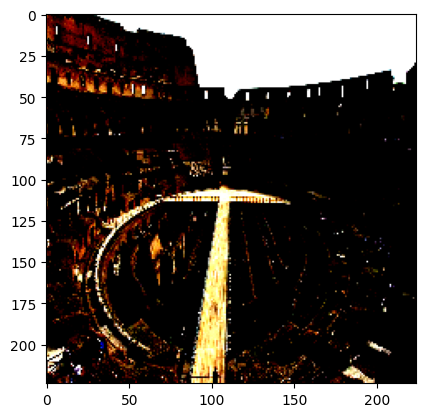

In [9]:
data = Wonders(data_brute)
im, label = data[72]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [10]:
def get_model():
  model = models.resnet18(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False

  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
  model.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(512, 128),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(128, 12))

  loss_fn = nn.MSELoss()
  parameter = model.parameters()
  optimizer = torch.optim.Adam(parameter,lr= 1e-3)
  return model.to(device), loss_fn, optimizer

In [11]:
!pip install torch_summary
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224))

/home/kaiserman/ML/transfer_learning/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kaiserman/ML/transfer_learning/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

In [12]:
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

In [13]:
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  prediction = model(x)
  is_correct = (prediction > 0.5) == y
  return is_correct.cpu().numpy().tolist()

In [14]:
def get_data():
  train = Wonders(train_data)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True, \
  drop_last = True)
  test = Wonders(test_data)
  test_dl = DataLoader(test, batch_size=32, shuffle=True, drop_last = True)
  val = Wonders(test_data)
  val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
  return trn_dl, test_dl, val_dl

In [15]:
trn_dl, test_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [20]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(10):
  print(f" epoch {epoch + 1}/5")
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies = []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    # print(y)
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()

  for ix, batch in enumerate(iter(test_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    val_epoch_accuracies.extend(val_is_correct)
  val_epoch_accuracy = np.mean(val_epoch_accuracies)

  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_accuracies.append(val_epoch_accuracy)

 epoch 1/5
 epoch 2/5
 epoch 3/5
 epoch 4/5
 epoch 5/5
 epoch 6/5
 epoch 7/5
 epoch 8/5
 epoch 9/5
 epoch 10/5


/tmp/ipykernel_19366/3269124104.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \


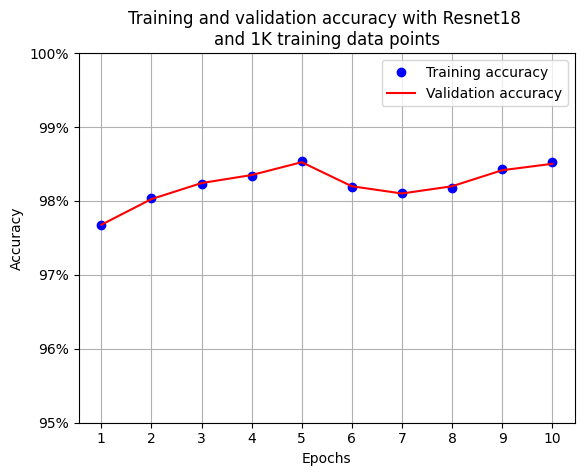

In [22]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo',
label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r',
label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
with Resnet18 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()